In [85]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_

import numpy as np
from numpy.random import normal, randint, choice

import scipy as sp
from scipy.special import softmax

import matplotlib.pyplot as plt

In [2]:
####################################################
# NOTES : SARSA DOES NOT CONVERGE TO THE CORRECT VALUE

In [3]:
def t_every(s, s_t):
    return [t.item() for t in np.argwhere(s[:-1] == s_t)]

In [4]:
def t_first(s, s_t):
    return t_every(s, s_t)[0]

In [5]:
states  = np.array([0, 1, 2, 0, 0, 2, 1, 1, 0, 2])
actions = np.array([0, 1, 0, 0, 0, 0, 1, 1, 0])
rewards = np.array([1, 4, 9, 1, 0, 3, 8, 1, 0])

In [6]:
class World():
    """
    Attributes
    ----------
    S : int
        number of states
        
    A : int
        number of actions
    
    P : np.array [S, A, S]
        transition probabilities
        
    R : np.array [S, A]
        rewards
    """
    def __init__(self, S, A):
        self.A = A
        self.S = S
        
        self.P = softmax(normal(size = (S,A,S)), axis = -1)
        self.R = randint(10, size = (S,A))
        
        # optimal policy for markov world
        self.gamma = 0.5
        
    def step(self, s, a):
        """
        Arguments
        ---------
        s : int
        a : int
        
        Returns
        -------
        r : np.array[]
        s_next : int
        """
        r = self.R[s,a]
        s_next = choice(self.S, p = self.P[s,a])
        return r, s_next
    
    
    def V_next(self, V, pi):
        """ V(s) - Value-State, k-step

        Arguments
        ---------
        pi : np.array[S]
        V : np.array[S]

        Returns
        -------
        V : np.array[S]
        """
        # V_k+1(s_i) = R(s,pi(s_i)) + sum(j): P(s_j | s_i, pi(s_i)) * V_k(s_i),  for i = 1,...,N
        V_next = np.stack([self.R[s, pi[s]] \
                         + self.gamma * (self.P[s, pi[s]] * V).sum()
                           for s in range(self.S)])
        return V_next
    
    
    def V(self, pi):
        """ V(s) - State-Value
        Arguments
        ---------
        -
        
        Returns
        -------
        V : np.array[N]
        """
        k = 0
        while True:
            if k == 0:
                V = np.zeros_like(self.S)
            if k >= 1:
                V_prev = V
                V = self.V_next(V, pi)
                if np.linalg.norm(V - V_prev) < 0.01:
                    break
            k+=1
        return V  
    
    
    def Q(self, a, pi):
        """ Q(s,a) - Action-State-Value
        
        Arguments
        ---------
        a : int
        
        Returns
        -------
        Q : np.array[N]
        """
        Q = np.stack([self.R[s,a] \
                    + self.gamma * (self.P[s,a] * self.V(pi)).sum() 
                      for s in range(self.S)])
        return Q

In [7]:
class Agent():
    def __init__(self):
        self.world = None
        self.pi = None
        self.s = None
        self.gamma = 0.5
        
    def Gt(self, states, actions, rewards):
        """
        Arguments
        ---------
        gamma : float

        sequence : np.array[T]
        actions : np.array[T-1]
        rewards : np.array[T-1]

        Returns
        -------
        G : np.array[]
        """
        T = len(states)
        G = np.stack([self.gamma ** (t+1) * rewards[t] for t in range(T-1)]).sum()
        return G
    
    def init_Q(self):
        return np.zeros((self.world.S, self.world.A))
    
    def init_V(self):
        return np.zeros(self.world.S)
    
    def init_pi(self):
        self.pi = softmax(normal(world.A, size = world.R.shape), axis = -1)
        
    def init_state(self, random = False):
        if random:
            self.s = choice(self.world.S)
        else:
            self.s = 0
            
    def choose_action(self, sample = True):
        if sample:
            a = choice(self.world.A, p = self.pi[self.s])
        else:
            a = self.pi[self.s].argmax()
        return a
    
    def take_action(self, a):
        r, s = self.world.step(self.s, a)
        self.s = s
        return r

    def sample_episode(self):
        states = list()
        actions = list()
        rewards = list()
        states.append(self.s)
        for t in range(self.T):
            a = self.choose_action(sample = True)
            r = self.take_action(a)
            states.append(self.s)
            actions.append(a)
            rewards.append(r)
        return np.array(states), np.array(actions), np.array(rewards)
    
    
    def Q(self):
        raise NotImplementedError()
        
        
    def V(self):
        raise NotImplementedError()
    
    
    def greedy(self, Q, eps):
        """
        Arguments
        ---------
        Q : np.array[S,A]
        eps : float

        Returns
        -------
        pi : np.array[S,A]
        """
        a_opt = Q.argmax(axis = 1)
        pi = np.ones_like(Q) * (eps/(Q.shape[1]-1))
        pi[range(Q.shape[0]), a_opt] = 1-eps
        return pi
    
    def place_into_world(self, world, alpha = 0.1):
        self.alpha = alpha
        self.world = world
        self.init_pi() 
        self.init_state()
        
    def learn(self, k):
        Q = self.init_Q()
        k = 1
        while True:
            s,a,r = self.sample_episode()
            Q = self.Q(Q,s,a,r)
            if k < 2000:
                self.pi = self.greedy(Q, eps = (1/k)**0.5)
            else:
                self.pi = self.greedy(Q, eps = 0)
                break
            k += 1

In [18]:
class MCFirstAgent(Agent):
    def __init__(self):
        super(MCFirstAgent, self).__init__()
        self.T = 20
        
    def V(self, V, s, a, r):
        """
        Arguments
        ---------
        gamma : float

        sequence : np.array[T]
        actions : np.array[T-1]
        rewards : np.array[T-1]

        Returns
        -------
        V : np.array[S]
        """
        for s_t in np.unique(s[:-1]):
            t = t_first(s, s_t)
            V[s] = self.Gt(s[t:], a[t:], r[t:])
        return V
    
    
    def Q(self, Q, s, a, r):
        """
        Arguments
        ---------
        gamma : float

        sequence : np.array[T]
        actions : np.array[T-1]
        rewards : np.array[T-1]

        Returns
        -------
        Q : np.array[S,A]
        """
        for s_t in np.unique(s[:-1]):
            t = t_first(s, s_t)
            Q[s[t],a[t]] = self.Gt(s[t:], a[t:], r[t:])
        return Q
    
    def G_first(self, s, a, r):
        """
        Arguments
        ---------
        sequence : np.array[T]
        actions : np.array[T-1]
        rewards : np.array[T-1]

        Returns
        -------
        V : np.array[S]
        """
        G = np.zeros(self.world.S)
        for s_t in np.unique(s[:-1]):
            t = t_first(s, s_t)
            G[s[t]] = self.Gt(s[t:], a[t:], r[t:])
        return G

In [16]:
class MCEveryAgent(Agent):
    def __init__(self):
        super(MCEveryAgent, self).__init__()
        self.T = 20
        
    def V(self, V, s, a, r):
        """
        Arguments
        ---------
        sequence : np.array[T]
        actions : np.array[T-1]
        rewards : np.array[T-1]

        Returns
        -------
        V : np.array[N]
        """
        for s_t in np.unique(s[:-1]):
            for t in t_every(s, s_t):
                V[s] += self.alpha * (self.Gt(s[t:], a[t:], r[t:]) - V[s])
        return V

    def Q(self, Q, s, a, r):
        """
        Arguments
        ---------
        gamma : float

        s : np.array[T]
        a : np.array[T-1]
        r : np.array[T-1]

        Returns
        -------
        Q : np.array[S, A]
        """ 
        for s_t in np.unique(s[:-1]):
            for t in t_every(s, s_t):
                Q[s[t],a[t]] += self.alpha * (self.Gt(s[t:], a[t:], r[t:]) - Q[s[t],a[t]])
        return Q

In [10]:
class TDAgent(Agent):
    def __init__(self):
        super(TDAgent, self).__init__()
        self.T = 2
    
    def V(self, V, s, a, r):
        """
        Arguments
        ---------
        gamma : float

        sequence : np.array[T]
        actions : np.array[T-1]
        rewards : np.array[T-1]

        Returns
        -------
        V : np.array[S]
        """
        V[s[0]] += self.alpha * ((r[0] + self.gamma * V[s[1]]) - V[s[0]])
        return V
    
    
    def Q(self, Q, s, a, r):
        """
        Arguments
        ---------
        gamma : float

        sequence : np.array[T]
        actions : np.array[T-1]
        rewards : np.array[T-1]

        Returns
        -------
        Q : np.array[S, A]
        """  
        Q[s[0],a[0]] += self.alpha * ((r[0] + self.gamma * Q[s[1],a[1]]) - Q[s[0],a[0]])
        return Q

In [11]:
class QAgent(Agent):
    def __init__(self):
        super(QAgent, self).__init__()
        self.T = 2
        
    def V(self, V, s, a, r):
        """
        Arguments
        ---------
        gamma : float

        sequence : np.array[T]
        actions : np.array[T-1]
        rewards : np.array[T-1]

        Returns
        -------
        V : np.array[S]
        """
        V[s[0]] += self.alpha * ((r[0] + self.gamma * V[s[1]]) - V[s[0]])
        return V
    
    
    def Q(self, Q, s, a, r):
        """
        Arguments
        ---------
        gamma : float

        sequence : np.array[T]
        actions : np.array[T-1]
        rewards : np.array[T-1]

        Returns
        -------
        Q : np.array[S, A]
        """  
        Q_opt = np.stack([Q[s[1],a] for a in range(self.world.A)]).max()
        Q[s[0],a[0]] += self.alpha * ((r[0] + self.gamma * Q_opt) - Q[s[0],a[0]])
        return Q

In [12]:
world = World(S = 3, A = 2)
world.R

array([[4, 8],
       [2, 8],
       [8, 5]])

In [13]:
agents = list()
agents.append(MCEveryAgent()) # niedrige Q werte aber richtiges pi
agents.append(MCFirstAgent()) # niedrige Q werte aber richtiges pi
agents.append(TDAgent()) 
agents.append(QAgent()) 

In [130]:
class V_function(nn.Module):
    def __init__(self, d_x):
        super().__init__()
        self.lin = nn.Sequential(
            nn.Linear(d_x, d_x),
            nn.ReLU(),
            nn.Linear(d_x, 1))
            
    def forward(self, x):
        """
        Arguments
        ---------
        """
        V = self.lin(x)
        return V
    
    def loss_fn(self, V_pred, G):
        """
        Arguments
        ---------
        G : torch.tensor[1]
        V : torch.tensor[1]
        
        Returns
        -------
        MSE : torch.tensor[1]
        """
        MSE = ((G - V_pred) ** 2).sum()
        return MSE

In [124]:
def np2torch(x):
    if x.shape == ():
        x = x[np.newaxis, np.newaxis]
    if x.shape == (1,):
        x = x[:,np.newaxis]
    return torch.from_numpy(x).float()

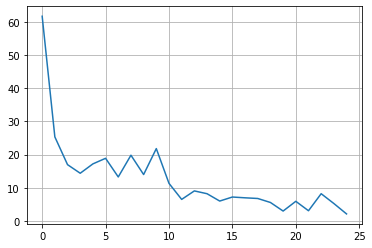

In [140]:
agent = TDAgent()
agent.place_into_world(world)
v_fun = V_function(1)
optimizer = Adam(v_fun.parameters(), lr = 0.01)

V = np.zeros(len(world.P))
train_loss = list()
loss_list = list()
for t in range(500):
    s,a,r = agent.sample_episode()
    V_gt = v_fun(np2torch(s[0]))
    V_pr = np2torch(r[0]) + 0.5 * v_fun(np2torch(s[1]))
    
    loss = v_fun.loss_fn(V_gt, V_pr)
    loss.backward()
    clip_grad_norm_(v_fun.parameters(), 5)
    optimizer.step()
    optimizer.zero_grad()
    
    loss_list.append(loss.detach())
    if t % 20 == 0:
        train_loss.append(torch.stack(loss_list).mean())
        loss_list = list()
plt.plot(train_loss)
plt.grid()

In [131]:
agent = MCFirstAgent()
agent.place_into_world(world)
v_fun = V_function(1)
optimizer = Adam(v_fun.parameters(), lr = 0.01)

train_loss = list()
for e in range(100):
    s,a,r = agent.sample_episode()
    G = agent.G_first(s,a,r)


    s = np2torch(s)
    G = np2torch(G)

    episode_loss = list()
    for i in range(len(G)):
        V_gt = G[i]
        V_pr = v_fun(s[i])
        loss = v_fun.loss_fn(V_pr, V_gt)

        loss.backward()
        clip_grad_norm_(v_fun.parameters(), 5)
        optimizer.step()
        optimizer.zero_grad()
        episode_loss.append(loss.detach())
    train_loss.append(torch.stack(episode_loss).mean())
    
plt.plot(train_loss)
plt.grid()

RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 2D